# Calculating rice cell growth parameters

The purposes of this document is to walk through the calculations of growth paramaters $\mu_{max}$ and the starting inocculation density $m_0$ from the rice cell growth experiments.

In [1]:
import numpy as np #importing important packages 
import matplotlib.pyplot as pt
import scipy.stats as st 
from scipy.stats import t


In [2]:
raw_data = [[8.75 , 7.218543046 , 6.933333333 , 2.88590604 , 5.874125874 , 5.570469799 , 3.285714286 , 3.020134228 , 1.824324324 , 3.886666667 , 4.256756757 , 5.1875 , 0.928571429 , 0.733333333 , 0.680272109] , 
[13.59477124 , 14.25531915 , 8.9375 , 11.18012422 , 12.30263158 , 9.533333333 , 6.490066225 , 6.845637584 , 5.297619048 , 8.75862069 , 9.6 , 7.533333333 , 3.642384106 , 7.032258065 , 2.795031056] , 
[17.4 , 16.86666667 , 12.125 , 15.51282051 , 12.17105263 , 16.66666667 , 10.63380282 , 8.421052632 , 10.50359712 , 11.70212766 , 12.07792208 , 11.17647059 , 3.164556962 , 3.267973856 , 1.8] , 
[14.5 , 12.08860759 , 11.86666667 , 12.1969697 , 12.93333333 , 15.98684211 , 13.69426752 , 14.13333333 , 16.05263158 , 11.0625 , 15.89285714 , 9.470198675 , 3.758389262 , 7.315436242 , 7.066666667] , 
[9.476744186 , 10.13333333 , 9.493670886 , 16.8 , 13.27044025 , 14.52229299 , 11.7 , 12.01342282 , 13.05732484 , 7.516778523 , 8.80952381 , 8.238993711 , 8.571428571 , 7.784431138 , 7.5]]

days = [0,2,4,6,8] #change when additional days are added 

In [3]:
nDays = len(days)
nFlasks = 5
nTrials = 3 
F_all = np.ndarray(shape = (nDays, nFlasks, nTrials), dtype = float)

i = 0 
j = 0 
flask = 0

#for rows in raw_data:
j = 0 
flask = 0 
for row in raw_data:
    j = 0
    flask = 0
    for num in row:
        F_all[i][flask][j-3*flask] = num
        #print("i is %d, flask is %d, j-3*flask is %d" % (i,flask,j-3*flask))

        if((j+1)%3==0):
            flask = flask + 1 
        j = j + 1

    i = i + 1     

F_avg = np.average(F_all,axis=2)
F_std = np.std(F_all,axis=2)

lF_all = np.log(F_all)
lF_avg = np.average(lF_all,axis=2)
lF_std = np.std(lF_all,axis=2)

Text(0,0.5,'log(g DW/L)')

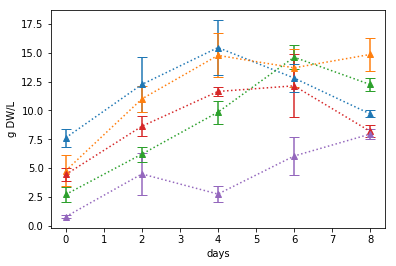

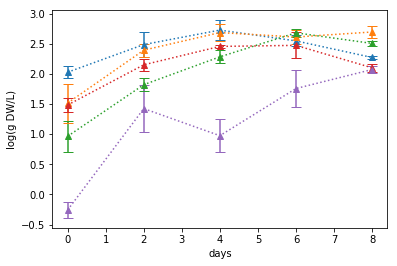

In [4]:
#plotting the data
pt.figure(1)
for i in range(0,5):
    pt.errorbar(days,F_avg[:,i],F_std[:,i],linestyle=':', marker='^',capsize=5)
pt.xlabel("days")
pt.ylabel("g DW/L")

pt.figure(2)
for i in range(0,5):
    pt.errorbar(days,lF_avg[:,i],lF_std[:,i],linestyle=':', marker='^',capsize=5)
pt.xlabel("days")
pt.ylabel("log(g DW/L)")

In [5]:
#this determines the end of the growth phase 
iGrowthEnds = np.ones(5)*len(days)
nDays = F_avg.shape[0]
nFlasks = F_avg.shape[1]
for i in range(0,nFlasks):
    prev = 0 
    innerCalled = 0 
    for j in range(0,nDays):
        current = F_avg[j][i]
        if(prev>current and not innerCalled):
            iGrowthEnds[i] = int(j)
            innerCalled = 1 
        else:
            prev = current
iGrowthEnds[4] = int(len(days)) #because of stupid error bar 
#iGrowthEnds[1] = 4 #because of stupid error bar 

for i in range(0,5):
    iGrowthEnds[i] = int(iGrowthEnds[i])
print(iGrowthEnds)


[3. 3. 4. 4. 5.]


Finally, we are onto the calculations 

In [6]:
#now converting to d, G notation 
m = np.size(days) 
n = 2 #two model parameters 

#making G 
col1 = np.ones((m,1))
col2 = np.transpose(days)
G = np.matrix(np.column_stack((col1,col2)))

#defining d matrix

d = np.matrix(lF_avg)
#defining sigma for data 
sigma_d = lF_std #s^2 != sigma^2 but we assume it does because what else?
print(d)


[[ 2.02734918  1.51595852  0.96536501  1.48410377 -0.25650843]
 [ 2.48569042  2.39291507  1.82038061  2.15037972  1.42366317]
 [ 2.72569298  2.68471264  2.2821635   2.45498686  0.97465664]
 [ 2.54671516  2.6109205   2.68046206  2.47252689  1.75645535]
 [ 2.2717655   2.69420094  2.50498757  2.10061642  2.07182105]]


using the formula $m = (G^{T}G)^{-1}G^Td$ that doesn't use the data's standard deviations 

In [7]:
#ignore ofr now 
#calculating m 
Gmaster = G.copy() 
beta_unw = np.ndarray(shape=(2,5),dtype=float)
for i in range(0,nFlasks):
    G = G[0:int(iGrowthEnds[i]),:]
    Gt = np.transpose(G)
    dtmp = d[0:int(iGrowthEnds[i]),i]
    beta_unw[:,i] = (np.linalg.inv(Gt*G)*Gt*dtmp).flatten()
    G = Gmaster.copy() 
print(beta_unw)

[[2.06373896 1.61348501 1.09603169 1.65001784 0.19612732]
 [0.17458595 0.29218853 0.2803537  0.16349382 0.24947256]]


using the formulas $G_{w} = WG$, $d_{w}=Wd$ and $\beta = (G^T_wG_{w})^{-1}G_{w}^Td_{w}$

In [8]:
#calculating m taking into account std 
beta_w = np.ndarray(shape=(2,5),dtype=float) #m wieghted 
betaCov_w = np.ndarray(shape=(5),dtype=np.matrix) #3d array of coviarance matricies 

for i in range(0,nFlasks):
    G = G[0:int(iGrowthEnds[i]),:]
    dtmp = d[0:int(iGrowthEnds[i]),i]    
    W = np.diag(1./sigma_d[0:int(iGrowthEnds[i]),i])
    Gw = W*G
    Gwt = np.transpose(Gw)
    dw = W*dtmp
    beta_w[:,i] = (np.linalg.inv(Gwt*Gw)*Gwt*dw).flatten()
    betaCov_w[i] = (np.linalg.inv(Gwt*Gw)*Gwt*np.identity(int(iGrowthEnds[i]))*Gw*np.linalg.inv(Gwt*Gw))
    #print(x.shape)
    #betaCov_w[:][:][i]
    #calculating covariance matrix
    #invGwtGw = np.linalg.inv(Gwt*Gw) #thiis could be cleaned up. Will do later 
    #print((invGwtGw*Gwt*np.identity(m)*Gw*invGwtGw))
    #print(x)
    G = Gmaster.copy()
#print(beta_w)
print(beta_w)

[[ 2.0379144   1.88244318  1.2886628   1.62611454 -0.15508071]
 [ 0.17878657  0.2164302   0.23559837  0.20552857  0.27979772]]


Calculating the coviarance matrix for beta $Cov(m_{L2}) = (G^T_wG_w)^{-1}G_w^TCov(d_w)G_w(G_w^TG_w)^{-1}$
we assume $Cov(d_w) = I_m $ since the data should be linearly independent measurements.

In [9]:
#invGwtGw = np.linalg.inv(Gwt*Gw) 
#np.identity(m)
#cov_m = invGwtGw*Gwt*np.cov(dw)*Gw*invGwtGw
#cov_m = invGwtGw*Gwt*np.identity(m)*Gw*invGwtGw
#print(cov_m)

$\mu$ is with a standard deviation of 

In [10]:
M0 = np.zeros(5)
M0_std = np.zeros(5)
mu_std = np.zeros(5)

for i in range(0,nFlasks):
    #print(cov_m)
    mu_std[i] = betaCov_w[i][1,1]
    print("mu_%d is = %0.3f +/- %0.4f" % (i+1,beta_w[1,i],betaCov_w[i][1,1]))
    M0[i] = np.exp(beta_w[0,i])
    M0_std[i] = betaCov_w[i][0,0]*M0[i]
    print("starting inocculation density is %0.3f +/- %0.4f"%(M0[i],M0_std[i]))

    print("")

mu_1 is = 0.179 +/- 0.0022
starting inocculation density is 7.675 +/- 0.0753

mu_2 is = 0.216 +/- 0.0049
starting inocculation density is 6.570 +/- 0.2565

mu_3 is = 0.236 +/- 0.0008
starting inocculation density is 3.628 +/- 0.0654

mu_4 is = 0.206 +/- 0.0007
starting inocculation density is 5.084 +/- 0.0513

mu_5 is = 0.280 +/- 0.0003
starting inocculation density is 0.856 +/- 0.0133



We use the following hypothosis testing framework $T_0 = \frac{| {{ \hat{\beta_1}-\beta_{1,0}| }}}{SE(\hat{\beta_1})}$ with the assumption that $SE(\hat{\beta_1}) = \sigma_{{\beta_1}}$ and $\beta_{1,0} = 0 $

In [11]:
#hypothosis testing prob that these things are real 
for i in range(0,nFlasks):
    sigma_b = betaCov_w[i][0,0] #SE
    sigma_mu = betaCov_w[i][1,1]
    
    T0_mu = abs(beta_w[0,i]-0)/sigma_mu #for slope 
    T0_b = abs(beta_w[1,i]-0)/sigma_b #for slope 

    p_mu = (1 - t.cdf(T0_mu,df=m-n))*2
    p_b = (1 - t.cdf(T0_b,df=m-n))*2 

    print("flask %d: p_mu is %.2E and p_b is %.2E" %(i+1,p_mu,p_b))


flask 1: p_mu is 2.91E-09 and p_b is 3.61E-04
flask 2: p_mu is 3.81E-08 and p_b is 1.16E-02
flask 3: p_mu is 4.57E-10 and p_b is 9.66E-04
flask 4: p_mu is 1.76E-10 and p_b is 2.59E-04
flask 5: p_mu is 1.60E-08 and p_b is 3.71E-04


[[ 18.29881072 -62.35683271]]

[[ 0.01894805 -0.06936291]
 [-0.06936291  0.25600125]]
flask 5: p_mu is 1.53E-07 and p_b is 1.77E-06


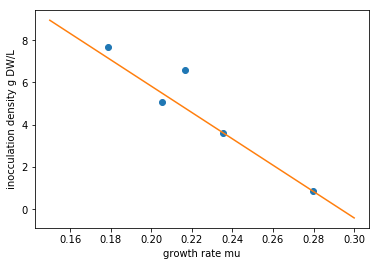

In [12]:
col1 = np.ones((5,1))
col2 = np.transpose(beta_w[1,:])
G = np.matrix(np.column_stack((col1,col2)))
d = np.matrix(M0).transpose()

W = np.diag(1./M0_std)
Gw = W*G
Gwt = np.transpose(Gw)
dw = np.matrix(W*d)

beta_muM0 = (np.linalg.inv(Gwt*Gw)*Gwt*dw).flatten()
betaCov_muM0 = (np.linalg.inv(Gwt*Gw)*Gwt*np.identity(int(iGrowthEnds[i]))*Gw*np.linalg.inv(Gwt*Gw))
print(beta_muM0)
print("")
print(betaCov_muM0)
xPoints = np.linspace(0.15,0.30,num=100)
pt.figure(3)
pt.plot(beta_w[1,:],M0,'o')
pt.xlabel("growth rate mu")
pt.ylabel("inocculation density g DW/L")
pt.plot(xPoints,beta_muM0[0,1]*xPoints+beta_muM0[0,0],'-')

T0_mu = abs(beta_muM0[0,1]-0)/betaCov_muM0[1,1] #for slope 
T0_b = abs(beta_w[0,0]-0)/betaCov_muM0[0,0]  #for slope 
p_mu = (1 - t.cdf(T0_mu,df=m-n))*2
p_b = (1 - t.cdf(T0_b,df=m-n))*2 
print("flask %d: p_mu is %.2E and p_b is %.2E" %(i+1,p_mu,p_b))


[[ 0.29395535 -0.01662093]]

[[ 1.41414596e-07 -4.06788058e-08]
 [-4.06788058e-08  2.20044283e-08]]

flask 5: p_mu is 0.00E+00 and p_b is 0.00E+00


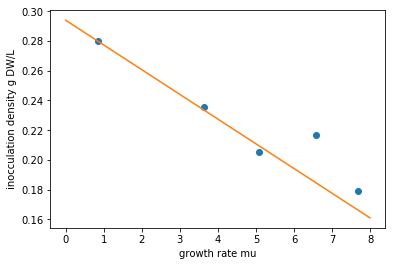

In [22]:
#now mu 
col1 = np.ones((5,1))
col2 = np.transpose(np.matrix(M0))
G = np.matrix(np.column_stack((col1,col2)))
d = np.matrix(beta_w[1,:]).transpose()
W = np.diag(1./mu_std)
Gw = W*G
Gwt = np.transpose(Gw)
dw = np.matrix(W*d)

beta_muM0 = (np.linalg.inv(Gwt*Gw)*Gwt*dw).flatten()
betaCov_muM0 = (np.linalg.inv(Gwt*Gw)*Gwt*np.identity(int(iGrowthEnds[i]))*Gw*np.linalg.inv(Gwt*Gw))
print(beta_muM0)
print("")
print(betaCov_muM0)
print("")
xPoints = np.linspace(0,8,num=100)
pt.figure(3)
pt.plot(M0,beta_w[1,:],'o')
pt.xlabel("growth rate mu")
pt.ylabel("inocculation density g DW/L")
pt.plot(xPoints,beta_muM0[0,1]*xPoints+beta_muM0[0,0],'-')

T0_mu = abs(beta_muM0[0,1]-0)/betaCov_muM0[1,1] #for slope 
T0_b = abs(beta_w[0,0]-0)/betaCov_muM0[0,0]  #for intercept 

p_mu = (1 - t.cdf(T0_mu,df=m-n))*2
p_b = (1 - t.cdf(T0_b,df=m-n))*2 
print("flask %d: p_mu is %.2E and p_b is %.2E" %(i+1,p_mu,p_b))



Determining if there is a relation between inocculation density and growth rate 